<div class="alert alert-block alert-success"> 
 NHANES Example
</div>

Load the libraries being used in the demo including the dill libray to pickle the data handler once they were loaded.

In [4]:
import dill as pickle
from cosinorage.datahandlers import NHANESDataHandler, plot_enmo
from cosinorage.features import WearableFeatures, dashboard
from cosinorage.bioages import CosinorAge

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Binary flag indicating if the data handler should be reloaded from the data files (True) or just loaded from the pickle file (False).

In [5]:
reload_nhanes = True

Load the data from patient specified by seqn into the NHANESDataHandler object from the data files which are located at the specified file directory. 

In [6]:
if reload_nhanes:
    nhanes_handler = NHANESDataHandler(nhanes_file_dir='../data/nhanes/', seqn=62177, verbose=True)
    with open("pickle/nhanes_handler.pkl", "wb") as file:
        pickle.dump(nhanes_handler, file)
else:
    with open("pickle/nhanes_handler.pkl", "rb") as file:
        nhanes_handler = pickle.load(file)

Found 1 versions of NHANES data: ['G']


Reading day-level files: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


Read 9 day-level records for person 62177


Processing chunks for version G: 782it [01:14, 10.49it/s], ?it/s]
Reading minute-level files: 100%|██████████| 1/1 [20:29<00:00, 1229.81s/it]


Read 11529 minute-level records for person 62177


Reading header files: 100%|██████████| 1/1 [00:14<00:00, 14.82s/it]

Merged header and minute-level data for person 62177
Renamed columns and set timestamp index for person 62177
Loaded 10080 minute-level Accelerometer records from ../data/nhanes/
Filtered out 0 minute-level ENMO records due to incomplete daily coverage
Filtered out 0 minute-level ENMO records due to filtering for longest consecutive sequence of days
Calculated ENMO data
Resampled 10080 to 10080 timestamps
__load_data executed in 1244.95 seconds



/Users/jacquesleooscar/Documents/Education/ETHZ/Curriculum/Semester04/04MasterThesis/CosinorAge/cosinorage/datahandlers/utils/nhanes.py:247: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  


Printing out the metadata which was collected during data loading.

In [7]:
nhanes_handler.get_meta_data()

{'datasource': 'nhanes',
 'raw_n_datapoints': 10080,
 'raw_start_datetime': Timestamp('1900-01-02 00:00:00'),
 'raw_end_datetime': Timestamp('1900-01-08 23:59:00'),
 'raw_data_frequency': 'minute-level',
 'raw_data_type': 'accelerometer',
 'raw_data_unit': 'MIMS',
 'n_days': 7}

Plotting the preprocessed ENMO data.

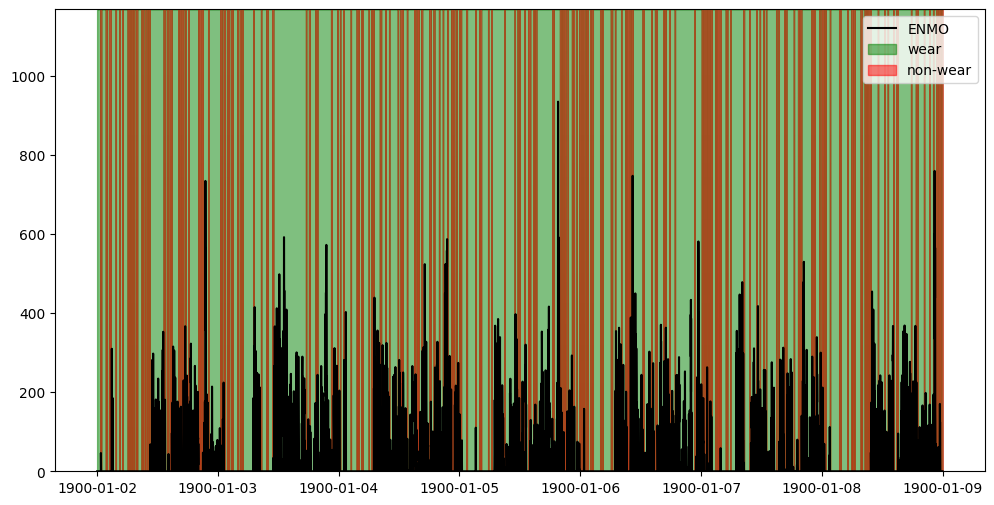

In [8]:
plot_enmo(nhanes_handler)

Setting hyperparameters for the sleep detection algorithm (sleep_ck_sf, sleep_rescore) and the cutpooint for the physical activity detection algorithm (pa_cutpoint_sl (cutpoint sedentary to light), pa_cutpoint_lm (cutpoint light to moderate), pa_cutpoint_mv (cutpoint moderate to vigorous)). sleep_ck_sf is a scale factor used in the sleep prediction algorithm - it needs to be adjusted depending on the data source and desired sensitivity of sleep detection.

In [9]:
features_args = {
    'sleep_ck_sf': 0.0025,
    'sleep_rescore': True,
    'pa_cutpoint_sl': 15,
    'pa_cutpoint_lm': 70,
    'pa_cutpoint_mv': 130,
}

Compute a wide range of variable features and plot them in the dashboard below.

In [10]:
features = WearableFeatures(nhanes_handler, features_args)

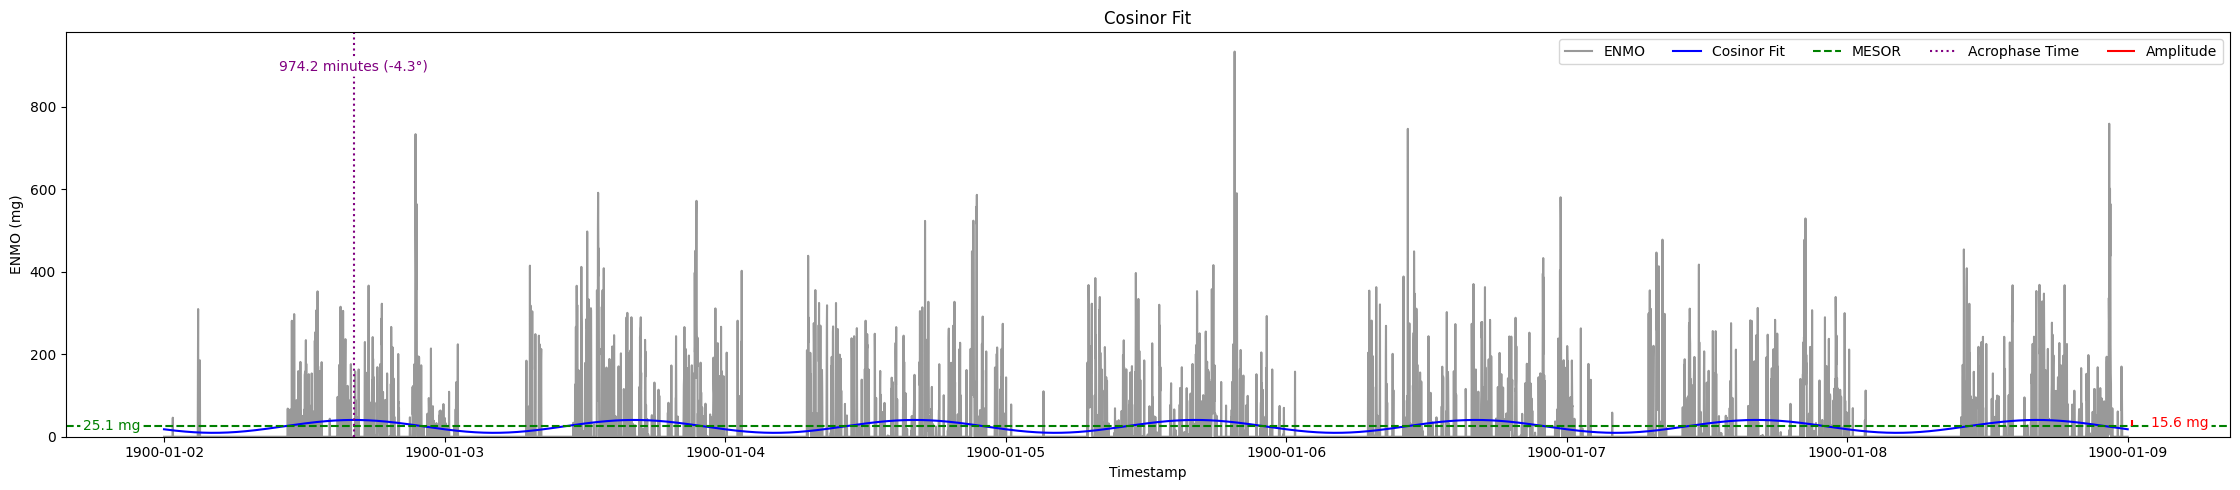

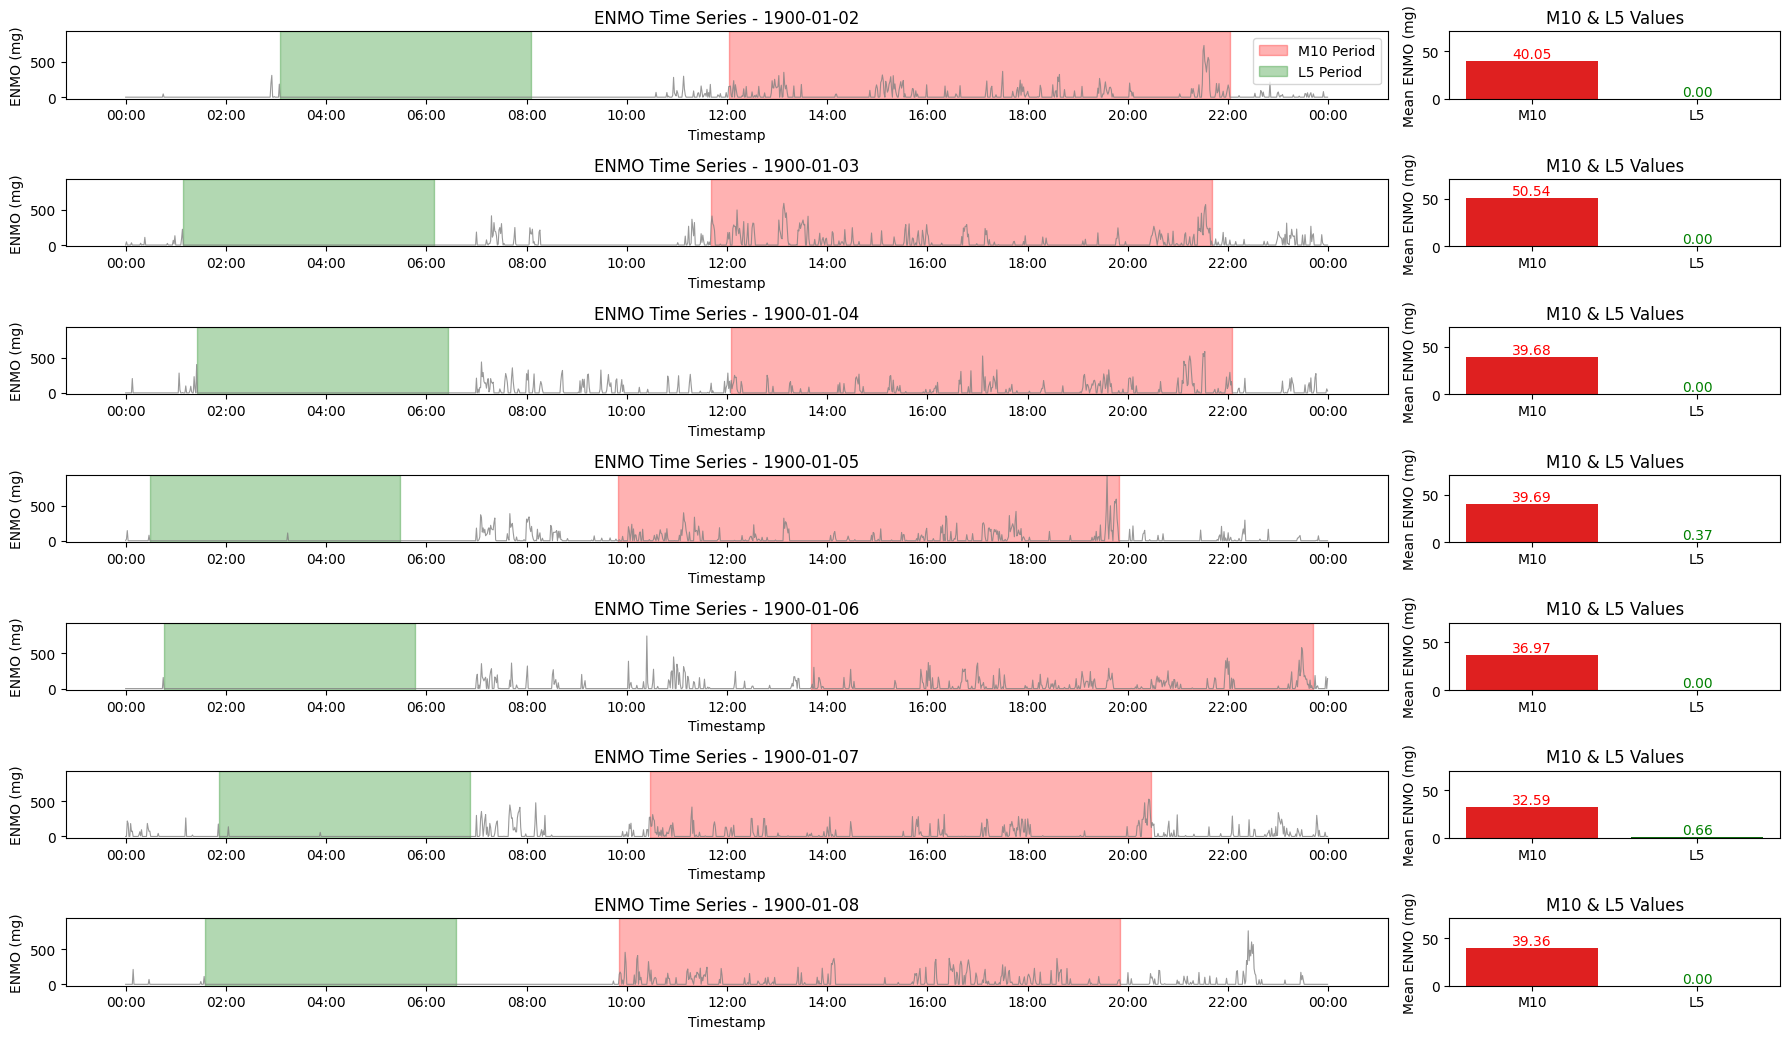

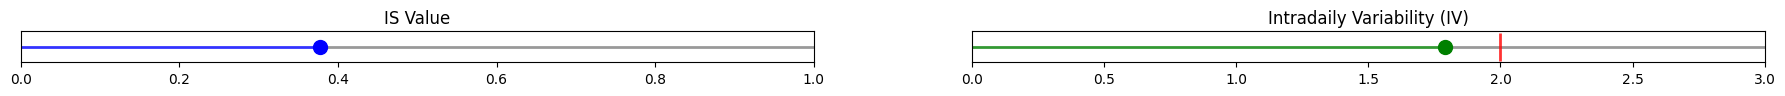

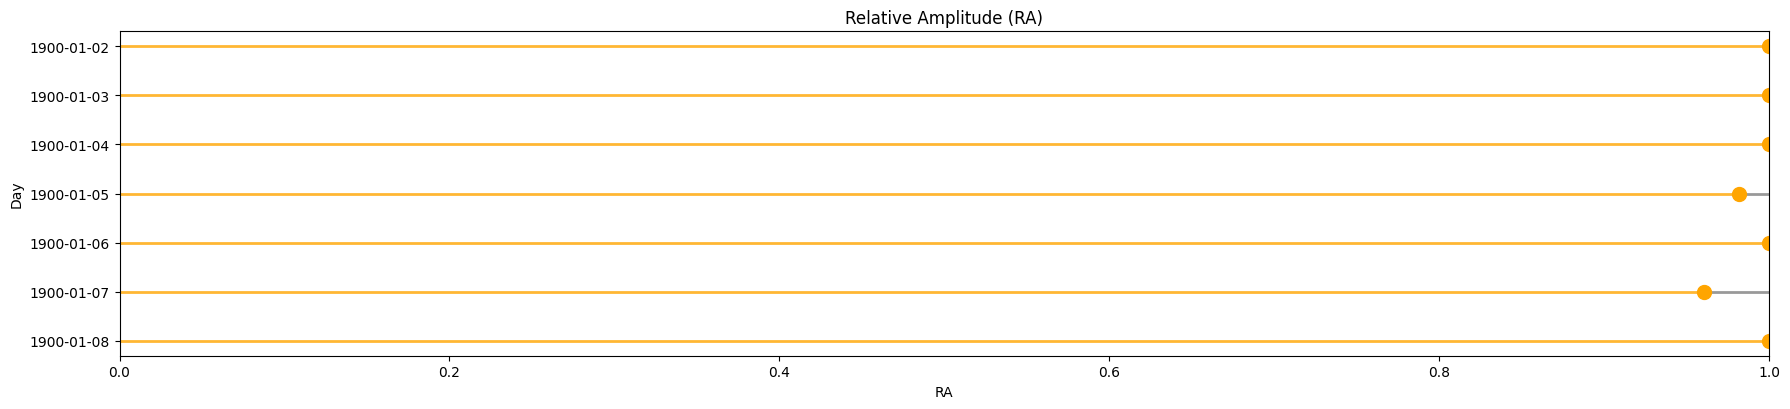

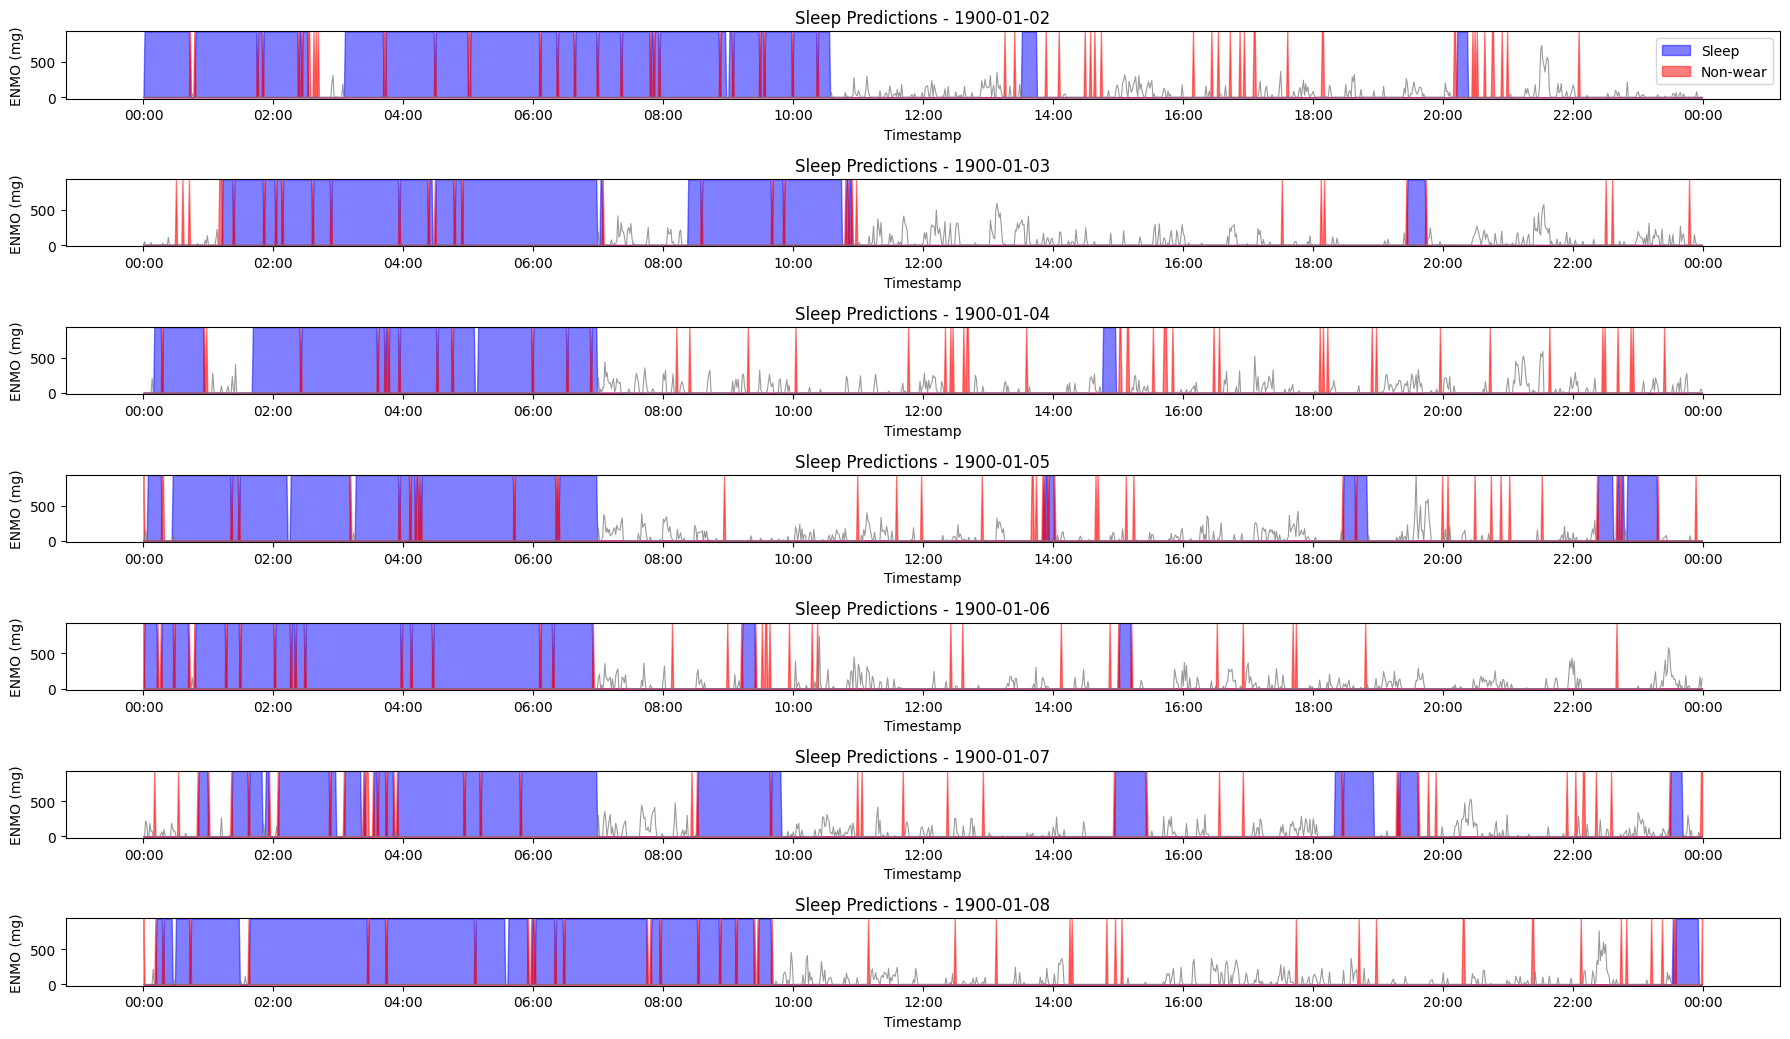

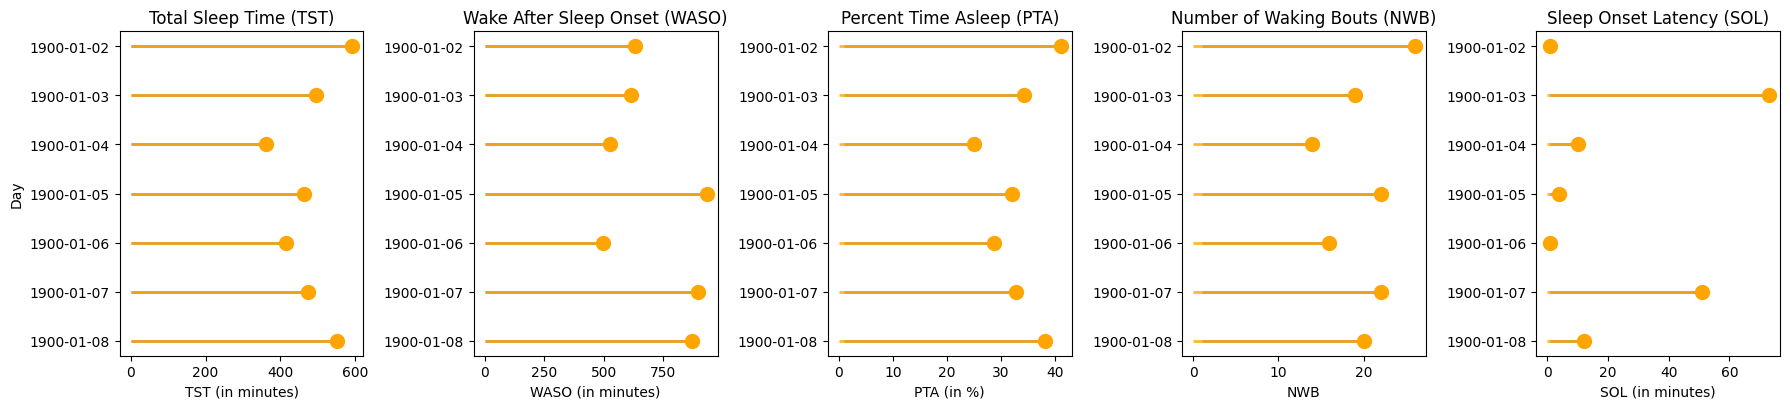

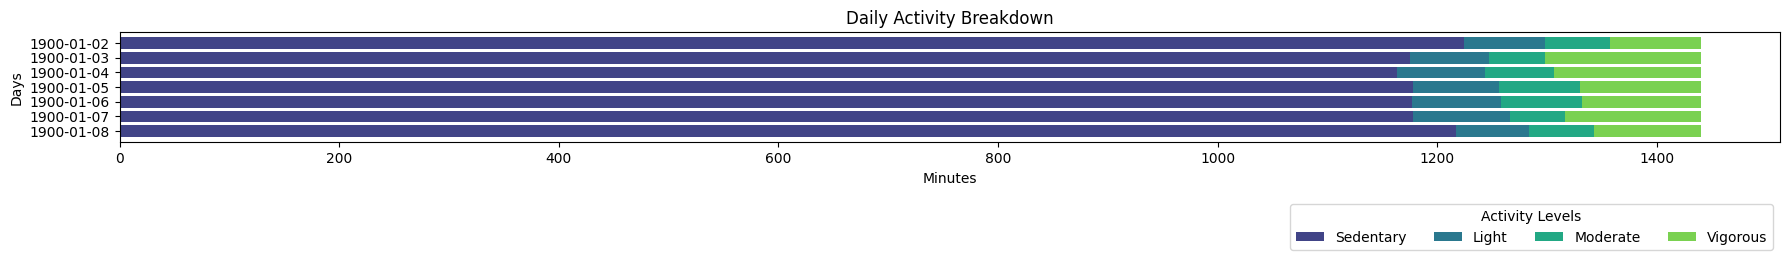

In [11]:
dashboard(features)

Defining utility function for quality control and validating of the predicted Cosinorage age values by loading the ground truth data and extracting the chronological age and gender of the patient.

In [12]:
import pandas as pd
def get_chrono_age_and_gender(file_path, seqn):
    data = pd.read_csv(file_path)
    data = data[data['seqn'] == seqn]
    age = data['age'].values[0]
    if data['sex'].values[0] == 'Male':
        gender = 'male'
    elif data['sex'].values[0] == 'Female':
        gender = 'female'
    else:
        gender = 'unknown'
    return int(age), gender

def get_gt_cosinor_age(file_path, seqn):
    data = pd.read_csv(file_path)
    data = data[data['seqn'] == seqn]
    gt_cosinor_age = data['cosinor_age'].values[0]
    return float(gt_cosinor_age)

Setting up input data structure for CosinorAge object containing the data handler (ENMO data), the chronological age, the gender, and the ground truth Cosinor age.

In [13]:
records = [
    {'handler': nhanes_handler, 
     'age': get_chrono_age_and_gender('../data/Age_sex_data/nhanes_age_sex.csv', 62177)[0], 
     'gender': 'unknown', 
     'gt_cosinor_age': get_gt_cosinor_age('../data/Age_sex_data/nhanes_cosinor_age.csv', 62177)
    }
]

Visualizing the predicted Cosinor age in contrast to the chronological age.

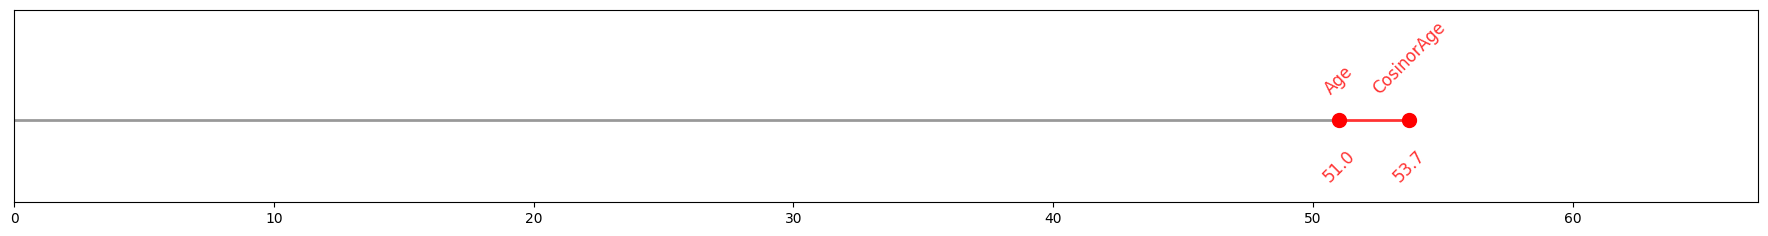

In [14]:
cosinor_age = CosinorAge(records)
cosinor_age.plot_predictions()

Printing the parameters of the CosinorAge model, including the cosinor anaysis parameters, the chrono age, the gender, and the predicted Cosinor age (as well as the ground truth Cosinor age we got from the validation data).

In [15]:
cosinor_age.get_predictions()

[{'handler': <cosinorage.datahandlers.nhanesdatahandler.NHANESDataHandler at 0x31a629ac0>,
  'age': 51,
  'gender': 'unknown',
  'gt_cosinor_age': 53.7112035189498,
  'mesor': np.float64(25.05895798312778),
  'amp1': np.float64(15.616759814682894),
  'phi1': np.float64(-4.250754500310476),
  'cosinorage': 53.714689092435435,
  'cosinorage_advance': 2.714689092435435}]